In [1]:
from model import encoder, decoder
from util import datasets
from torchvision import transforms, utils
from torch.utils.data import DataLoader
from train import train
from model import encoder, decoder, image_encoder
from torchvision.utils import make_grid
from torch.distributions.normal import Normal
import os
import cv2
import loss
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
PARAM_CHAIRS = {
    'train': '/home/anatolios/project/All_in_one/FlyingChairs/',
    'test': '/home/julia0607/Flying Chairs/testing',
    'name': 'FlyingChairs',
    'dtype': 'image'
}
BATCH_SIZE = 64
N_EPOCHS = 30
LR = 1e-4
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def prepare_data(param, transformation):
    """
    Return dataloader of given parameters
    """
    # Extract parameters
    path_train, path_test, name, dtype = param['train'], param['test'], param['name'], param['dtype']
    
    # Create dataset for train and test path
    data_train = datasets.Datasets(path_train, name, dtype, transforms=transformation, img_size=224)
#     print(data_train[0][1].shape)
#     data_test = datasets.Datasets(path_test, name, dtype, transforms=transformation)

    # Create dataloader for train and test
#     dataloader_train = DataLoader(dataset=data_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
#     dataloader_test = DataLoader(dataset=data_test, batch_size=BATCH_SIZE, shuffle=True)
    return data_train, data_train

In [4]:
# trans = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#         ])
# fc_train, _ = prepare_data(PARAM_CHAIRS, trans)
trans = transforms.Compose([
            transforms.ToTensor(),
#             transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
kth_dataset = datasets.KTHDataset('./data/kth/raw/', transforms=trans, img_size=64)
kth_train = DataLoader(dataset=kth_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [5]:
def imshow(img):
    """
    Show image from normalized tensor data
    """
    img = img.numpy().transpose((1, 2, 0))
#     mean = np.array([0.5, 0.5, 0.5])
#     std = np.array([0.5, 0.5, 0.5])
#     img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

In [6]:
def combine_plot(img_1, img_2, img_pred, idx, save_path):
    print(img_1.shape)
    print(img_2.shape)
    print(img_pred.shape)
    img_1_p = imshow(img_1)
    img_2_p = imshow(img_2)
    img_pred_p = imshow(img_pred)
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(img_1_p)
    axs[0].set_title('Image 1')
    axs[1].imshow(img_2_p)
    axs[1].set_title('Image 2')
    axs[2].imshow(img_pred_p)
    axs[2].set_title('Prediction')
    fig.savefig(os.path.join(save_path, '{:0>2d}.jpg'.format(idx)), dpi=150)
    plt.close(fig)

In [7]:
model = {
    'encoder' : encoder(channel_in=6, vae = False),
    'decoder' : decoder(channel_in=3, f_extracter=True),
#     'image_encoder' : image_encoder()
}
model['encoder'].load_state_dict(torch.load('saved/0930_2/weight_encoder.pt'))
model['decoder'].load_state_dict(torch.load('saved/0930_2/weight_decoder.pt'))
# model['image_encoder'].load_state_dict(torch.load('saved/0915_1/weight_image_encoder.pt'))

print('best weight loaded!')

best weight loaded!


In [8]:
# SAVE_PATH = 'saved/0904_2/results'
# if not os.path.exists(SAVE_PATH):
#     os.makedirs(SAVE_PATH)
# with torch.no_grad():
#     model['encoder'].eval()
#     model['decoder'].eval()
    
#     img_1, img_2 = next(iter(m_train))
# #     img_1, img_2 = img_1.to(DEVICE), img_2.to(DEVICE)
#     z = model['encoder'](img_2, img_1)
#     img_pred = model['decoder'](z, img_1)
    
#     img_1_d = img_1.cpu()
#     img_2_d = img_2.cpu()
#     img_pred_d = img_pred.cpu()
    
#     img_1_grid = make_grid(img_1_d).numpy().transpose((1, 2, 0))
#     img_2_grid = make_grid(img_2_d).numpy().transpose((1, 2, 0))
#     img_pred_grid = make_grid(img_pred_d).numpy().transpose((1, 2, 0))
    
#     # Plot the results side-by-side
#     f, axarr = plt.subplots(1, 3)
#     axarr[0].imshow(img_1_grid)
#     axarr[0].set_title('img_1')

#     axarr[1].imshow(img_2_grid)
#     axarr[1].set_title('img_2')
    
#     axarr[2].imshow(img_pred_grid)
#     axarr[2].set_title('img_pred')
    
#     f.savefig(os.path.join(SAVE_PATH, 'result.jpg'), dpi=1000)
#     plt.close(f)

In [9]:
SAVE_PATH = 'saved/0930_2/results'
np.random.seed(0)
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
for i in range(30):
    idx = np.random.randint(len(kth_dataset))
    img_1, img_2 = kth_dataset[idx]
    img_1, img_2 = img_1.unsqueeze(0), img_2.unsqueeze(0)
    with torch.no_grad():
        model['encoder'].eval()
        model['decoder'].eval()
#         model['image_encoder'].eval()
#         c_list = model['image_encoder'](img_1)
        if model['encoder'].vae == False:
            z = model['encoder'](img_2, img_1)
        else:
            z, _, _ = model['encoder'](img_2, img_1)
        img_pred = model['decoder'](z, img_1)
        
    combine_plot(img_1.squeeze(), img_2.squeeze(), img_pred.squeeze(), i, SAVE_PATH)

torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 6

In [12]:
SAVE_PATH = 'saved/0930_2/samples'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
for i in range(30):
    idx = np.random.randint(len(kth_dataset))
    img_1, img_2 = kth_dataset[idx]
    img_1, img_2 = img_1.unsqueeze(0), img_2.unsqueeze(0)
    with torch.no_grad():
        model['encoder'].eval()
        model['decoder'].eval()
        z = Normal(torch.zeros(1 * 32 * 8 * 8), torch.ones(1 * 32 * 8 * 8)).sample()
        z = z.view(1, 32, 8, 8)
        img_pred = model['decoder'](z, img_1)
    combine_plot(img_1.squeeze(), img_2.squeeze(), img_pred.squeeze(), i, SAVE_PATH)

torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 6

In [25]:
img, flow = fc_train[0]

In [26]:
flow.max()

tensor(1.2667)

In [27]:
flow.min()

tensor(-1.5985)

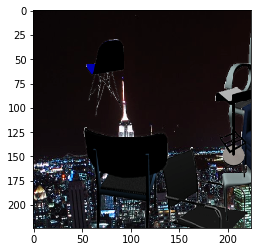

In [28]:
plt.imshow(imshow(img.squeeze()))

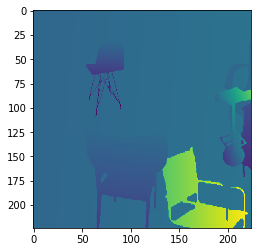

In [29]:
# plt.imshow(flowshow(flow.squeeze()))
plt.imshow(flow.squeeze()[1, ...])

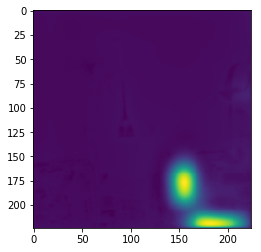

In [30]:
# print(flow_recon.shape)
# plt.imshow(flowshow(flow_recon.squeeze()))
with torch.no_grad():
    img, flow = img.unsqueeze(0), flow.unsqueeze(0)
    model['encoder'].eval()
    model['decoder'].eval()
    z = model['encoder'](flow, img)
    flow_recon = model['decoder'](z, img)
flow_recon = flow_recon.squeeze()
plt.imshow(flow_recon[1, ...])

In [111]:
flow_recon[0, 1, ...]

tensor([[ 9.4991e-01,  1.1864e+00,  1.4348e+00,  ...,  2.2063e-01,
          3.5680e-02,  9.6990e-03],
        [ 9.1465e-01,  1.1609e+00,  1.4190e+00,  ...,  3.0544e-01,
          2.4370e-01,  6.1492e-02],
        [ 8.7939e-01,  1.1354e+00,  1.4033e+00,  ...,  4.5870e-01,
          2.6490e-01,  2.0064e-01],
        ...,
        [-5.0882e-01, -4.7673e-01, -3.7326e-01,  ..., -5.7224e-01,
         -4.2356e-01, -3.8337e-01],
        [-4.5146e-01, -5.3913e-01, -3.3863e-01,  ..., -4.8808e-01,
         -3.4247e-01, -2.6907e-01],
        [-4.3690e-01, -5.5112e-01, -3.8597e-01,  ..., -3.0266e-01,
         -2.3988e-01, -1.3233e-01]])

In [16]:
flow[0, 1, ...]

tensor([[  -760.8721,   -758.4517,   -756.0310,  ...,   -225.9265,
           -223.5059,   -221.0853],
        [  -760.0421,   -757.6216,   -755.2010,  ...,   -225.0964,
           -222.6758,   -220.2553],
        [  -759.2121,   -756.7915,   -754.3710,  ...,   -224.2664,
           -221.8458,   -219.4252],
        ...,
        [  -577.4357,   -575.0152,   -572.5946,  ...,    -27.4095,
            -24.9854,    -25.8498],
        [  -576.6057,   -574.1852,   -571.7646,  ...,    -26.0168,
            -24.6323,    -36.8189],
        [  -575.7757,   -573.3551,   -570.9345,  ...,    -24.6240,
            -38.4094,    -35.9888]])

In [10]:
test = torch.randn([2, 2, 2, 2])
test

tensor([[[[ 0.1113,  0.8739],
          [-0.3846,  0.1514]],

         [[ 1.8741, -1.6189],
          [ 1.2808, -0.7930]]],


        [[[ 2.2111, -1.1702],
          [ 1.2015, -0.2090]],

         [[ 0.1677,  0.0593],
          [ 1.4618, -0.6723]]]])

In [11]:
test = torch.nn.functional.softmax(test)

/home/tao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


In [12]:
test

tensor([[[[ 0.1464,  0.9236],
          [ 0.1590,  0.7200]],

         [[ 0.8536,  0.0764],
          [ 0.8410,  0.2800]]],


        [[[ 0.8853,  0.2263],
          [ 0.4353,  0.6138]],

         [[ 0.1147,  0.7737],
          [ 0.5647,  0.3862]]]])

In [14]:
test[0, :, 0, 0]

tensor([ 0.1464,  0.8536])